In [0]:
!pip install face_recognition

In [0]:
from imutils import paths
import argparse
import pickle
import cv2
import os

In [0]:
imagePaths = list(paths.list_images('sample_data/images'))

In [0]:
imagePaths

['sample_data/images/dp3.jpeg', 'sample_data/images/dp4.jpeg']

In [0]:
knownEncodings = []
knownNames = []

In [0]:
for (i, imagePath) in enumerate(imagePaths):
	print("[INFO] processing image {}/{}".format(i + 1,
		len(imagePaths)))
	name = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

[INFO] processing image 1/2
[INFO] processing image 2/2


In [0]:
with open('sample_data/encode_faces.py',mode='r') as fp:
  data=fp.read()

In [0]:
import face_recognition

RuntimeError: ignored

In [0]:
boxes = face_recognition.face_locations(rgb,model="cnn")
encodings = face_recognition.face_encodings(rgb, boxes)
for encoding in encodings:
		# add each encoding + name to our set of known names and
		# encodings
		knownEncodings.append(encoding)
		knownNames.append(name)

In [0]:
print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
f = open(encodings.pickle, "wb")
f.write(pickle.dumps(data))
f.close()

2nd approach

In [0]:
from imutils import paths
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os


In [0]:
detector= cv2.dnn.readNetFromCaffe('/content/deploy.prototxt.txt', '/content/res10_300x300_ssd_iter_140000.caffemodel')

In [12]:
# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch("sample_data/openface_nn4.small2.v1.t7")

[INFO] loading face recognizer...


In [23]:
print("[INFO] quantifying faces...")
imagePaths = list(paths.list_images("sample_data/Dataset"))
knownEmbeddings = []
knownNames = []
total = 0

[INFO] quantifying faces...


In [24]:
imagePaths

['sample_data/Dataset/unknown/own_grady.jpg',
 'sample_data/Dataset/unknown/claire_dearing.jpg',
 'sample_data/Dataset/unknown/ian_malcolm.jpg',
 'sample_data/Dataset/unknown/john_hammond.jpg',
 'sample_data/Dataset/unknown/ellie_sattler.jpg',
 'sample_data/Dataset/unknown/alan_grant.jpg',
 'sample_data/Dataset/trisha/00000.png',
 'sample_data/Dataset/trisha/00004.png',
 'sample_data/Dataset/trisha/00003.png',
 'sample_data/Dataset/trisha/00005.png',
 'sample_data/Dataset/trisha/00001.png',
 'sample_data/Dataset/trisha/00002.png',
 'sample_data/Dataset/andrian/00000.png',
 'sample_data/Dataset/andrian/00004.jpg',
 'sample_data/Dataset/andrian/00005.jpg',
 'sample_data/Dataset/andrian/00002.jpg',
 'sample_data/Dataset/andrian/00003.jpg',
 'sample_data/Dataset/andrian/00001.png']

In [0]:
for (i, imagePath) in enumerate(imagePaths):
	
	name = imagePath.split(os.path.sep)[-2]
	image = cv2.imread(imagePath)
	image = imutils.resize(image, width=600)
	(h, w) = image.shape[:2]
	imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)

	detector.setInput(imageBlob)
	detections = detector.forward()
 	
	if len(detections) > 0:
		i = np.argmax(detections[0, 0, :, 2])
		confidence = detections[0, 0, i, 2]
		if confidence > 0.5:

			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")
	
			face = image[startY:endY, startX:endX]
			(fH, fW) = face.shape[:2]
		
			if fW < 20 or fH < 20:
				continue
    
			faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,	(96, 96), (0, 0, 0), swapRB=True, crop=False)
			embedder.setInput(faceBlob)
			vec = embedder.forward()

			knownNames.append(name)
			knownEmbeddings.append(vec.flatten())
			total += 1
  

In [27]:
print("[INFO] serializing {} encodings...".format(total))
data = {"embeddings": knownEmbeddings, "names": knownNames}
f = open("sample_data/embeddings.pickle", "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] serializing 18 encodings...


In [0]:
# --embeddings output/embeddings.pickle \
# 	--detector face_detection_model \
# 	--embedding-model openface_nn4.small2.v1.t7

In [0]:
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import argparse
import pickle
import matplotlib.pyplot as plt

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-e", "--embeddings", required=True,
# 	help="path to serialized db of facial embeddings")
# ap.add_argument("-r", "--recognizer", required=True,
# 	help="path to output model trained to recognize faces")
# ap.add_argument("-l", "--le", required=True,
# 	help="path to output label encoder")
# args = vars(ap.parse_args())

In [30]:
print("[INFO] loading face embeddings...")
# data = pickle.loads(open("sample_data/embeddings.pickle", "rb").read())
# # encode the labels
# print("[INFO] encoding labels...")
le = LabelEncoder()
labels = le.fit_transform(data["names"])

[INFO] loading face embeddings...


In [31]:
labels

array([2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [32]:
# train the model used to accept the 128-d embeddings of the face and
# then produce the actual face recognition
print("[INFO] training model...")
recognizer = SVC(C=1.0, kernel="linear", probability=True)
recognizer.fit(data["embeddings"], labels)

[INFO] training model...


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
# write the actual face recognition model to disk
f = open("sample_data/recognizer.pickle", "wb")
f.write(pickle.dumps(recognizer))
f.close()
# write the label encoder to disk
f = open("sample_data/le.pickle", "wb")
f.write(pickle.dumps(le))
f.close()
# We write two pic

In [0]:
# train_model.py --embeddings output/embeddings.pickle \
	# --recognizer output/recognizer.pickle \
	# --le output/le.pickle

In [0]:
# import numpy as np
# import argparse
# import imutils
# import pickle
# import cv2
# import os
# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-i", "--image", required=True,
# 	help="path to input image")
# ap.add_argument("-d", "--detector", required=True,
# 	help="path to OpenCV's deep learning face detector")
# ap.add_argument("-m", "--embedding-model", required=True,
# 	help="path to OpenCV's deep learning face embedding model")
# ap.add_argument("-r", "--recognizer", required=True,
# 	help="path to model trained to recognize faces")
# ap.add_argument("-l", "--le", required=True,
# 	help="path to label encoder")
# ap.add_argument("-c", "--confidence", type=float, default=0.5,
# 	help="minimum probability to filter weak detections")
# args = vars(ap.parse_args())

In [0]:
# print("[INFO] loading face detector...")
# protoPath = os.path.sep.join([args["detector"], "deploy.prototxt"])
# modelPath = os.path.sep.join([args["detector"],"res10_300x300_ssd_iter_140000.caffemodel"])
# detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)
# # load our serialized face embedding model from disk
# print("[INFO] loading face recognizer...")
# embedder = cv2.dnn.readNetFromTorch(args["embedding_model"])
# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open("sample_data/recognizer.pickle", "rb").read())
le = pickle.loads(open("sample_data/le.pickle", "rb").read())

In [0]:
image = cv2.imread("/content/sample_data/Images/trisha_adrian.jpg")
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
imageBlob = cv2.dnn.blobFromImage(	cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
detector.setInput(imageBlob)
detections = detector.forward()

In [0]:
for i in range(0, detections.shape[2]):
	confidence = detections[0, 0, i, 2]
	
	if confidence > 0.5:
	
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")
		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]
		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			continue
    
		faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),(0, 0, 0), swapRB=True, crop=False)
		embedder.setInput(faceBlob)
		vec = embedder.forward()
		# perform classification to recognize the face
		preds = recognizer.predict_proba(vec)[0]
		j = np.argmax(preds)
		proba = preds[j]
		name = le.classes_[j]
    # draw the bounding box of the face along with the associated
		# probability
		text = "{}: {:.2f}%".format(name, proba * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),
			(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)


andrian: 47.51%


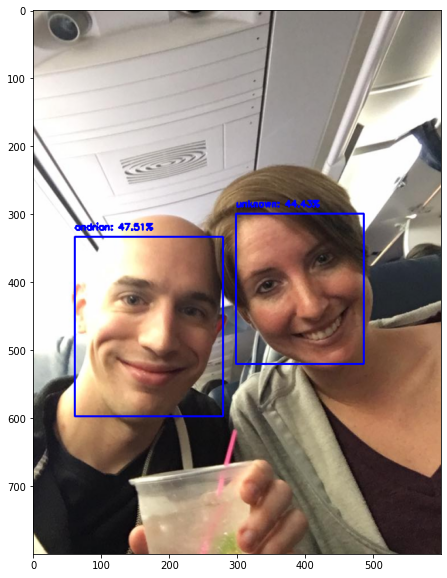

In [61]:
fig=plt.figure(figsize=(10,10))
plt.imshow(image)
print(text)

In [0]:
#  recognize.py --detector face_detection_model \
# 	--embedding-model openface_nn4.small2.v1.t7 \
# 	--recognizer output/recognizer.pickle \
# 	--le output/le.pickle \
# 	--image images/trisha_adrian.jpg 

In [0]:
# recognize.py --detector face_detection_model \
# 	--embedding-model openface_nn4.small2.v1.t7 \
# 	--recognizer output/recognizer.pickle \
# 	--le output/le.pickle \
# 	--image images/patrick_bateman.jpg 